In [1]:
import os, sys
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm

save_dir_name = 'stormer_perturb_forecasts'
diffs = np.load('../data/stormer_perturb_forecasts/diffs.npy')

save_dir = '/eagle/MDClimSim/mjp5595/data/{}/'.format(save_dir_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

background_file_np = '/eagle/MDClimSim/mjp5595/ml4dvar/background_init_stormer_norm.npy' # This is just to initialize the model background
background_f = np.load(background_file_np, 'r')
print('background_f.shape :',background_f.shape)

noise_levels = [0, 0.01, 0.1, 1, 10, 100, 1000]

background_f.shape : (1, 69, 128, 256)


hf.keys() : <KeysViewHDF5 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '5', '6', '7', '8', '9']>
forecast_orig.shape : (69, 128, 256)
Plotting noise level : 0.01
Plotting noise level : 0.1
Plotting noise level : 1
Plotting noise level : 10
Plotting noise level : 100
Plotting noise level : 1000
Plotting noise level : 0.01
Plotting noise level : 0.1
Plotting noise level : 1
Plotting noise level : 10
Plotting noise level : 100
Plotting noise level : 1000
mse_arr : []
noise_mses : {0.01: 2829.2146, 0.1: 83775.85, 1: 590593.94, 10: 6516208.0, 100: 18662494.0, 1000: 24744432.0}
mse_arr : [2829.2146, 83775.85, 590593.94, 6516208.0, 18662494.0, 24744432.0]


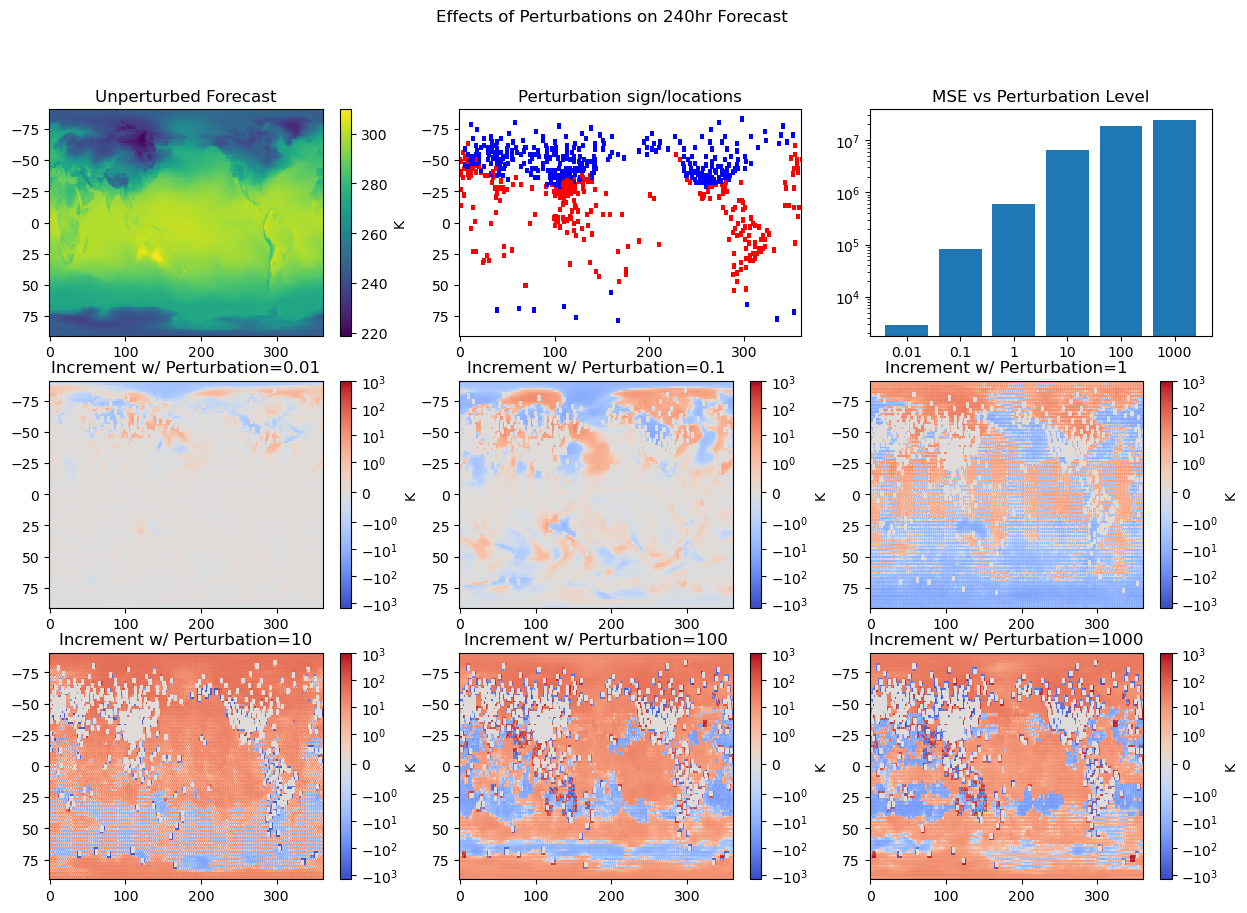

In [20]:
# Plotting the results
forecast_step = 39 
lon = np.linspace(0,360,256)
lat = np.linspace(90,-90,128)

#fig, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (15,10))
#fig, axs = plt.subplots(3, 3, figsize = (15,10))
fig = plt.figure(figsize=(15,10))
axs = []

# Get original forecast
axs00 = fig.add_subplot(331)
axs.append(axs00)
hf = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_levels[0])),'r')
print('hf.keys() :',hf.keys())
forecast_orig = hf[str(forecast_step)][0]
print('forecast_orig.shape :',forecast_orig.shape)
axs00.invert_yaxis()
pc_orig = axs00.pcolormesh(lon, lat, forecast_orig[0], cmap = 'viridis')
plt.colorbar(pc_orig, ax = axs00, label='K')
axs00.set_title('Unperturbed Forecast')

# plot perturbations
axs01 = fig.add_subplot(332, sharey=axs00, sharex=axs00)
axs.append(axs01)
perturbations = diffs[0]
cmap = colors.ListedColormap(['blue','white','red'])
bounds = [-1.5,-0.5,0.5,1.5]
#axs01.invert_yaxis()
perts = axs01.pcolormesh(lon, lat, perturbations[0], cmap=cmap)
axs01.set_title('Perturbation sign/locations')

######################################################################################################################
# This block is to get the min and max increment values
######################################################################################################################
inc_min = 0
inc_max = 0
for idx,noise_level in enumerate(noise_levels[1:]):
    print('Plotting noise level :',noise_level)
    hf = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_level)),'r')
    forecast_perturbed = hf[str(forecast_step)][0]

    increment = forecast_perturbed - forecast_orig
    increment = np.where(perturbations!=0,0,increment)
    inc_min = min(inc_min,np.min(increment[0]))
    inc_max = max(inc_max,np.max(increment[0]))
    #inc_min = min(inc_min,np.min(np.log(abs(increment))))
    #inc_max = max(inc_max,np.max(np.log(abs(increment))))
######################################################################################################################
######################################################################################################################

# get analysis and mse of perturbed forecasts
perts = []
noise_mses = {}
for idx,noise_level in enumerate(noise_levels[1:]):
    print('Plotting noise level :',noise_level)
    hf = h5py.File(os.path.join(save_dir, 'raw_forecast_noise{}.h5'.format(noise_level)),'r')
    forecast_perturbed = hf[str(forecast_step)][0]

    increment = forecast_perturbed - forecast_orig
    increment = np.where(perturbations!=0,0,increment)

    mse = np.mean(np.square(increment))
    noise_mses[noise_level] = mse

    str_int = '33' + str(idx+4)
    axs.append(fig.add_subplot(int(str_int), sharey=axs00, sharex=axs00))
    #axs[-1].invert_yaxis()
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.Normalize(inc_min,inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap='viridis', norm=colors.CenteredNorm(vmin=inc_min,vcenter=0,vmax=inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.CenteredNorm(vcenter=0)))

    #twoSlope = colors.TwoSlopeNorm(vmin=inc_min, vcenter=0, vmax=inc_max)
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap='viridis', norm=colors.LogNorm(inc_min,inc_max)))
    #perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=0.0001)))
    perts.append(axs[-1].pcolormesh(lon, lat, increment[0], cmap=cm.coolwarm, norm=colors.SymLogNorm(linthresh=1,vmin=inc_min,vmax=inc_max)))
    axs[-1].set_title('Increment w/ Perturbation={}'.format(noise_level))
    plt.colorbar(perts[-1], ax = axs[-1], label='K')

axs02 = fig.add_subplot(333)
axs.append(axs02)
#axs02._shared_y_axes.remove(axs[0, 2])
#axs02._shared_x_axes.remove(axs[0, 2])
axs02.set_yscale('log')
axs02.set_title('MSE vs Perturbation Level')
#mse_arr = np.zeros(len(noise_mses))
mse_arr = []
print('mse_arr :',mse_arr)
print('noise_mses :',noise_mses)
noise_levels_str = []
for idx,noise_level in enumerate(noise_levels[1:]):
    mse_arr.append(noise_mses[noise_level])
    noise_levels_str.append(str(noise_level))
print('mse_arr :',mse_arr)
#mse_scat = axs[0, 2].scatter(noise_levels[1:],mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:],legend=mse_arr)
#mse_scat = axs[0, 2].bar(np.arange(len(noise_levels[1:])),noise_levels[1:])
mse_scat = axs02.bar(noise_levels_str,mse_arr)
#axs[0, 2].set_xlabel(noise_levels[1:])

plt.suptitle('Effects of Perturbations on 240hr Forecast')
plt.savefig(save_dir+'perturb_sameCMap_240hr.png')

